In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Loading features

In [2]:
from feature_formation.feat_split import *    # Loading the features
from model_files.load_feats import *          # Loading the feature names

feat_m = meteo_list + ['vol'] + features_dict['micorfs_m']

pca_h = X_train.filter(regex='^pca_h_').columns.tolist()
feat_h = meteo_list + ['vol_lidar'] + pca_h

feat_m_l = meteo_list + ['vol_lidar_m'] + features_dict['micorfs_m']
feat_h_m = meteo_list + ['vol'] + pca_h

Train shape:  (390, 153)
Test shape:  (210, 153)


### Model Training

In [3]:
from src.misc import CustomStandardScaler
from model_files.gpr_model_func import gaussian_process_regression_with_tuning

scaler = CustomStandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_m, grid_m = gaussian_process_regression_with_tuning(X_train_scaled[feat_m], y_train, X_test_scaled[feat_m], y_test)
model_h, grid_h = gaussian_process_regression_with_tuning(X_train_scaled[feat_h], y_train, X_test_scaled[feat_h], y_test)

model_m_l, grid_m_l = gaussian_process_regression_with_tuning(X_train_scaled[feat_m_l], y_train, X_test_scaled[feat_m_l], y_test)
model_h_m, grid_h_m = gaussian_process_regression_with_tuning(X_train_scaled[feat_h_m], y_train, X_test_scaled[feat_h_m], y_test)

Model score: 0.8102326419477227
Model score: 0.7865669417725227
Model score: 0.7932842496578014
Model score: 0.8173554939078544


In [ ]:
Model score: 0.8102129537243228
Model score: 0.7893230103869732
Model score: 0.7932846477225637
Model score: 0.8229218742283293

### Results visualisation

#### functions

In [8]:
from tkinter import font
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
import ast
from src.misc import DAP

def plot_with_flight_num(predicted, actual, labels, title, std_dev = None, plot_number=False, save_fig=None, flt_to_plot=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']
    # Filter data if flt_to_plot is provided
    if flt_to_plot is not None:
        mask = flight_column.isin(flt_to_plot)
        predicted = predicted[mask]
        actual = actual[mask]
        if std_dev is not None:
            std_dev = std_dev[mask]
        flight_column = flight_column[mask]
        plot_column = plot_column[mask]

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2022'):
            marker = 'x'  # x
        elif str(flight_number).startswith('2023'):
            marker = '3'  # y
        else:
            marker = 'o'  # circle
        
        plt.scatter(actual[mask], predicted[mask], s=75, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)
        # If standard deviation is provided, plot confidence intervals
        if std_dev is not None:
            # Calculate the 95% confidence interval, assuming normal distribution
            ci = 1.96 * std_dev[mask]
            plt.errorbar(actual[mask], predicted[mask], yerr=ci, fmt='none', ecolor=color_map(i/len(unique_flights)), alpha=1, elinewidth=1, capsize=5)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual root yield (kg/m$^2$)', fontsize=18)
    plt.ylabel('Predicted root yield (kg/m$^2$)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=2, fontsize=13)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def model_evaluate(model, feat, labels, title, X_train, y_train, X_test, y_test, err_bar=False, plt_num=False, save_fig=None):
    _,train_std = model.predict(X_train[feat], return_std=True)
    predicted_mean, predicted_std = model.predict(X_test[feat], return_std=True)
    print('Train score: ',model.score(X_train[feat],y_train), ' RMSE:',root_mean_squared_error(y_train, model.predict(X_train[feat])), ' MAPE:',mean_absolute_percentage_error(y_train, model.predict(X_train[feat])), ' std_dev:',train_std.mean())
    print('Test score: ',model.score(X_test[feat],y_test), ' RMSE:',root_mean_squared_error(y_test, model.predict(X_test[feat])), ' MAPE:',mean_absolute_percentage_error(y_test, model.predict(X_test[feat])), ' std_dev:',predicted_std.mean())

    if err_bar:
        plot_with_flight_num(predicted_mean, y_test, labels, title=title, std_dev=predicted_std, plot_number=plt_num, save_fig=save_fig)
    else:
        plot_with_flight_num(model.predict(X_test[feat]),y_test,labels, title=title, plot_number=plt_num,save_fig=save_fig)

def evaluate_model_by_flight_combined(model, feat, X, y, labels, rmse= False, std=False):
    # This function evaluates a given model's performance by flight. It calculates R-squared 
    # and RMSE metrics for training, validation, and test datasets separately for each 
    # unique flight in the dataset. The function requires the model, features (feat), and 
    # labels containing flight information. It returns a DataFrame with flights as the 
    # index and the evaluation metrics for each dataset.
    results = []  # Initialize results list
    unique_flights = labels['Flight'].unique()  # Get unique flights from labels

    for flight in unique_flights:  # Iterate over each unique flight
        # Filter datasets for the current flight
        mask = labels['Flight'] == flight
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))
        mape_combined = mean_absolute_percentage_error(y_flt, model.predict(X_flt[feat]))

        # Append the results
        results.append({
            'Flight': flight,
            '$R^2$': r2_combined,
            'MAPE (%)': mape_combined*100
        })
        if rmse:
            results[-1]['RMSE ($kg/m^2$)'] = rmse_combined
        if std:
            _, predicted_std = model.predict(X_flt[feat], return_std=True)
            results[-1]['std_dev ($kg/m^2$)'] =  predicted_std.mean()

    # Return the results as a DataFrame with 'Flight' as the index
    df = pd.DataFrame(results)
    df.set_index('Flight', inplace=True)
    return df

def plot_heatmap(df, title=None):
    # Number of columns to plot
    num_columns = len(df.columns)
    
    # Create a figure with subplots arranged horizontally
    fig, axes = plt.subplots(1, num_columns, figsize=(num_columns * 3, 5), sharey=True)
    
    # Ensure axes is an array even when there's only one column
    if num_columns == 1:
        axes = np.array([axes])
    
    for i, column in enumerate(df.columns):
        # Create a temporary DataFrame for the current column
        temp_df = pd.DataFrame(df[column])
        
        # Plotting the heatmap for the current column
        sns.heatmap(temp_df, ax=axes[i], annot=True, cmap='Reds', fmt=".2f", annot_kws={'size': 18}, cbar=False)
        axes[i].set_title(f'{column}', fontsize=18)
        axes[i].tick_params(labelsize=16, rotation=0)
        axes[i].set_xticks([])

        # Set y-axis label only for the leftmost column
        if i == 0:
            axes[i].set_ylabel('Flight', fontsize=16)
        else:
            axes[i].set_ylabel('')
        
    
    # Set common labels
    if title:
        plt.suptitle(title, fontsize=20)
    else:
        plt.suptitle('Model Evaluation Metrics by Flight (mean)', fontsize=18)

    #plt.ylabel('Flight', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the title
    plt.show()

def plot_columns(df_, harvest_date, label, marker='o', fntsize=24, axes=None, annot=False):
    """
    Plot each column in separate axes, converting flight dates to DAP using the provided harvest date.

    Parameters:
    - df (pd.DataFrame): DataFrame with flight dates as index and columns to plot.
    - harvest_date (str): Harvest date string in the format 'YYYYMMDD' to use as reference date in DAP.
    - axes (list of plt.Axes, optional): List of external axes to plot on. If None, new axes will be created.

    Returns:
    - list of plt.Axes: List of axes of each plot.
    """
    # Convert flight dates to DAP
    df = df_.copy()
    dap_index = DAP(df.index, harvest_date)
    df.index = dap_index

    # Create new axes if not provided
    if axes is None:
        fig, axes = plt.subplots(ncols=len(df.columns), nrows=1, figsize=(8* len(df.columns), 6))

    # Ensure axes is a list
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]

    # Plot each column
    for i, column in enumerate(df.columns):
        axes[i].plot(df.index, df[column], label = harvest_date[:4]+'_'+label, marker=marker)
        axes[i].set_xlabel('DAP', fontsize=fntsize)
        axes[i].set_ylabel(column, fontsize=fntsize)
        #axes[i].set_title(f'{harvest_date[:4]}', fontsize=fntsize+2)
        axes[i].tick_params(axis='both', which='major', labelsize=fntsize-2)
        axes[i].legend(fontsize=fntsize-8)

        # Annotate each point if annot is True
        if annot:
            for x, y in zip(df.index, df[column]):
                axes[i].annotate(f'{y:.2f}', xy=(x, y), textcoords='offset points', xytext=(0, 5), ha='center', fontsize=fntsize - 2)


    plt.tight_layout()
    #plt.show()

    return axes

#### Results

Train score:  0.8761731233048363  RMSE: 0.46217009655782065  MAPE: 0.12308650057103  std_dev: 0.13471036584814874
Test score:  0.8102326419477227  RMSE: 0.577013061108459  MAPE: 0.1575859643298722  std_dev: 0.215353164312333


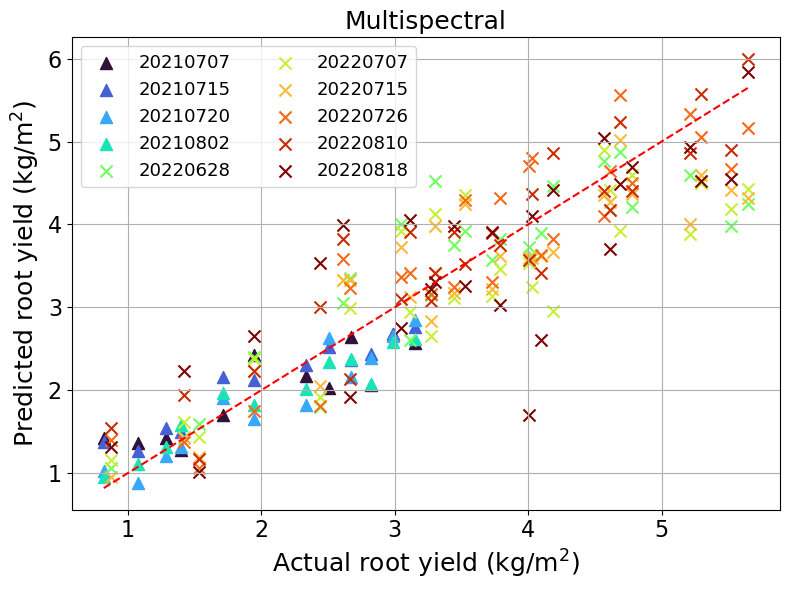

Train score:  0.8236833477856255  RMSE: 0.5514943257564999  MAPE: 0.15108587383656574  std_dev: 0.18302607210417346
Test score:  0.7865669417725227  RMSE: 0.6119356173837024  MAPE: 0.17454900362183065  std_dev: 0.2334787648550447


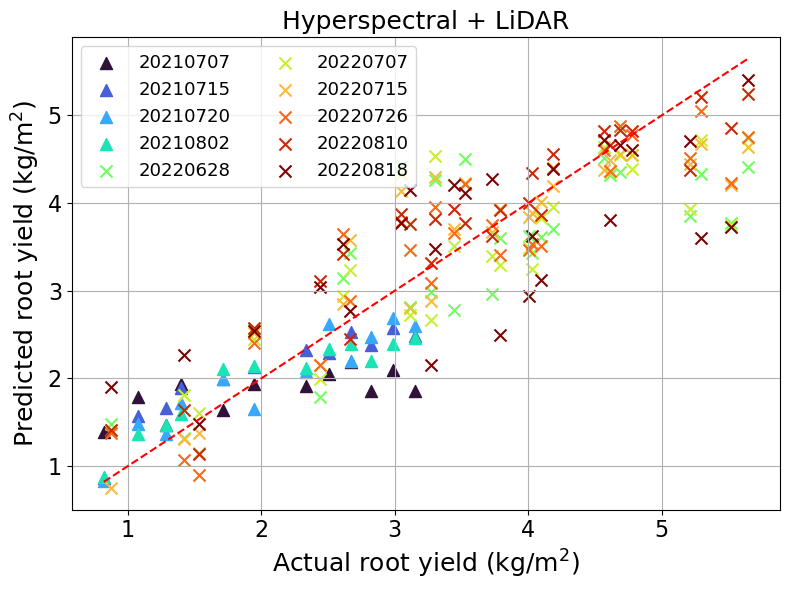

Train score:  0.8106734657030858  RMSE: 0.5714788016085016  MAPE: 0.152038085544366  std_dev: 0.18041716030896668
Test score:  0.7932842496578014  RMSE: 0.6022290102026613  MAPE: 0.18020941566874152  std_dev: 0.2235435122520729


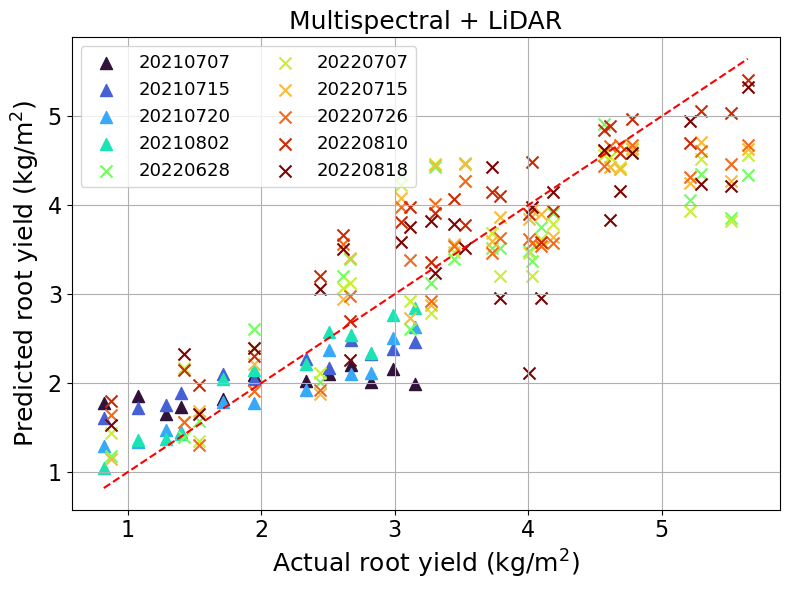

Train score:  0.8746077669638836  RMSE: 0.4650821817328064  MAPE: 0.12166664252736271  std_dev: 0.13619319232083352
Test score:  0.8173554939078544  RMSE: 0.566080499937269  MAPE: 0.1595906472311602  std_dev: 0.2180061775749004


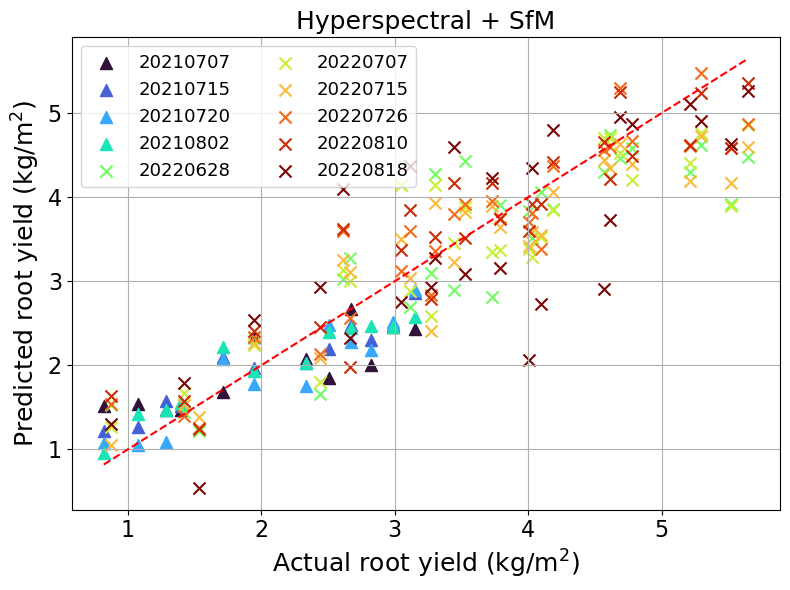

In [ ]:
from sklearn.preprocessing import StandardScaler

model_evaluate(model_m, feat_m, labels_test, 'Multispectral', X_train_scaled, y_train, X_test_scaled, y_test, err_bar=False)
model_evaluate(model_h, feat_h, labels_test, 'Hyperspectral + LiDAR', X_train_scaled, y_train, X_test_scaled, y_test, err_bar=False)
model_evaluate(model_m_l, feat_m_l, labels_test, 'Multispectral + LiDAR', X_train_scaled, y_train, X_test_scaled, y_test, err_bar=False)
model_evaluate(model_h_m, feat_h_m, labels_test, 'Hyperspectral + SfM', X_train_scaled, y_train, X_test_scaled, y_test, err_bar=False)

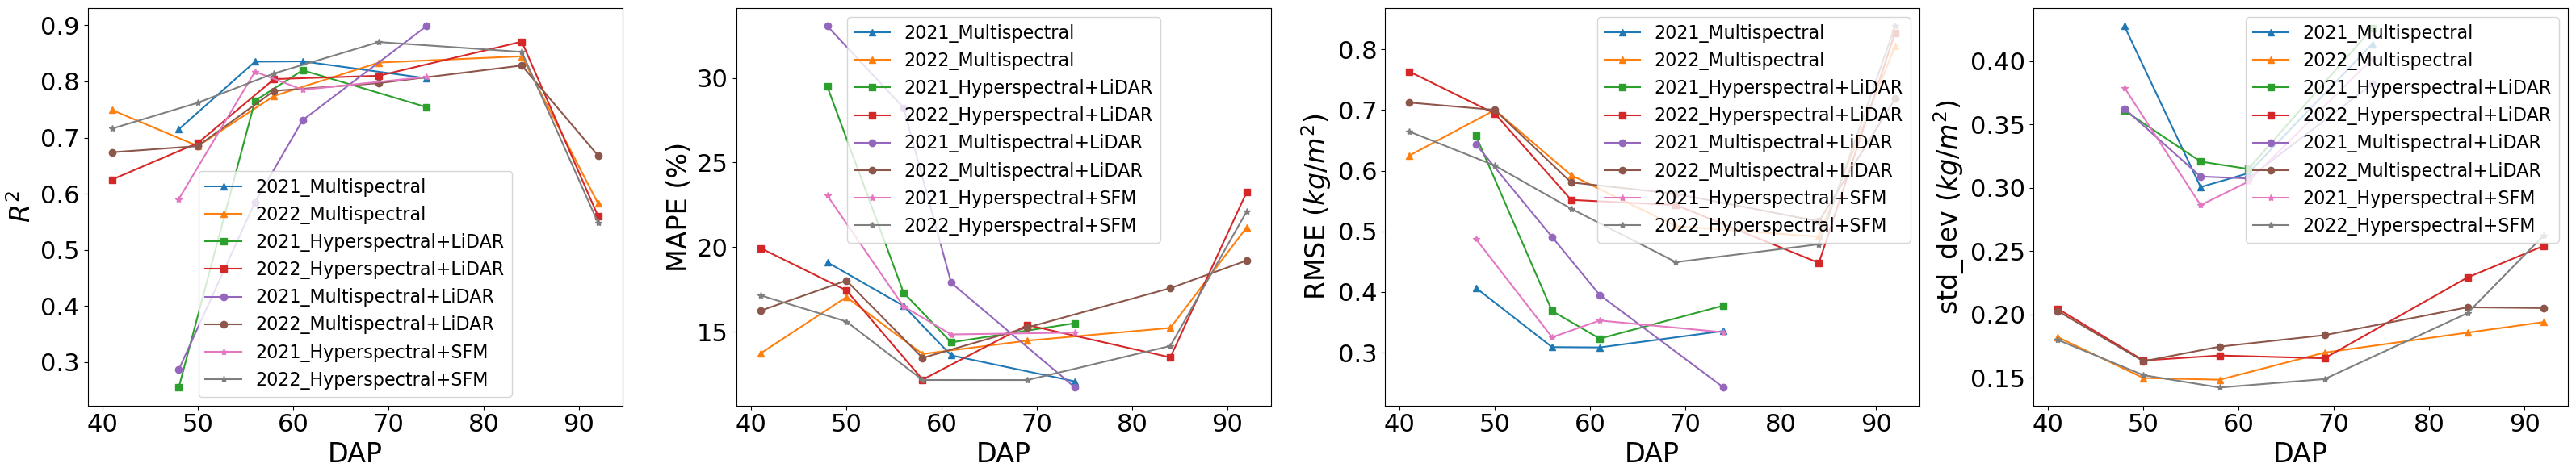

In [ ]:

metric_m_21 = evaluate_model_by_flight_combined(model_m, feat_m, scaler.transform(X_21_test), y_21_test, labels_21_test, std=True, rmse=True)
metric_h_21 = evaluate_model_by_flight_combined(model_h, feat_h, scaler.transform(X_21_test), y_21_test, labels_21_test, std=True, rmse=True)
metric_m_22 = evaluate_model_by_flight_combined(model_m, feat_m, scaler.transform(X_22_test), y_22_test, labels_22_test, std=True, rmse=True)
metric_h_22 = evaluate_model_by_flight_combined(model_h, feat_h, scaler.transform(X_22_test), y_22_test, labels_22_test, std=True, rmse=True)

metric_m_l_21 = evaluate_model_by_flight_combined(model_m_l, feat_m_l, scaler.transform(X_21_test), y_21_test, labels_21_test, std=True, rmse=True)
metric_m_l_22 = evaluate_model_by_flight_combined(model_m_l, feat_m_l, scaler.transform(X_22_test), y_22_test, labels_22_test, std=True, rmse=True)
metric_h_m_21 = evaluate_model_by_flight_combined(model_h_m, feat_h_m, scaler.transform(X_21_test), y_21_test, labels_21_test, std=True, rmse=True)
metric_h_m_22 = evaluate_model_by_flight_combined(model_h_m, feat_h_m, scaler.transform(X_22_test), y_22_test, labels_22_test, std=True, rmse=True)

multi_spectral_plots = plot_columns(metric_m_22, '20220518', label='Multispectral', marker='^', axes=plot_columns(metric_m_21, '20210520', label='Multispectral', marker='^'))
hyper_spectral_plots = plot_columns(metric_h_22, '20220518', label='Hyperspectral+LiDAR', marker = 's', axes=plot_columns(metric_h_21, '20210520', label='Hyperspectral+LiDAR', marker='s', axes=multi_spectral_plots))
multi_spectral_lidar_plots = plot_columns(metric_m_l_22, '20220518', label='Multispectral+LiDAR', axes=plot_columns(metric_m_l_21, '20210520', label='Multispectral+LiDAR', axes=multi_spectral_plots))
hyper_spectral_sfm_plots = plot_columns(metric_h_m_22, '20220518', label='Hyperspectral+SFM', marker = '*', axes=plot_columns(metric_h_m_21, '20210520', label='Hyperspectral+SFM', marker = '*', axes=hyper_spectral_plots))

### Understanding feature contribution

In [12]:
import shap
# Create model explainer with SHAP for multispectral model
explainer_all_m = shap.Explainer(model_m.predict, scaler.transform(X)[feat_m])
shap_values_all_m = explainer_all_m(scaler.transform(X)[feat_m])

c:\Users\ms4667\.conda\envs\multi_yield\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ExactExplainer explainer: 601it [06:28,  1.55it/s]                         


In [13]:
# Create model explainer with SHAP for hyperspectral + LiDAR model
explainer_all_h = shap.Explainer(model_h.predict, scaler.transform(X)[feat_h])
shap_values_all_h = explainer_all_h(scaler.transform(X)[feat_h])

ExactExplainer explainer: 601it [06:15,  1.55it/s]                         


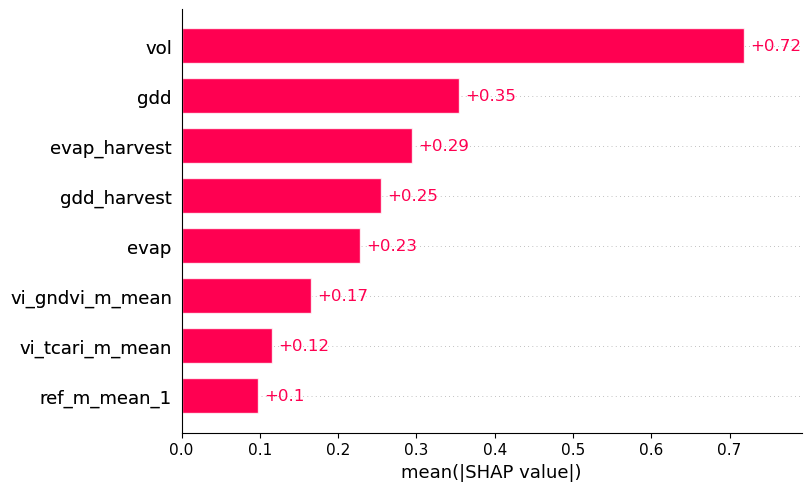

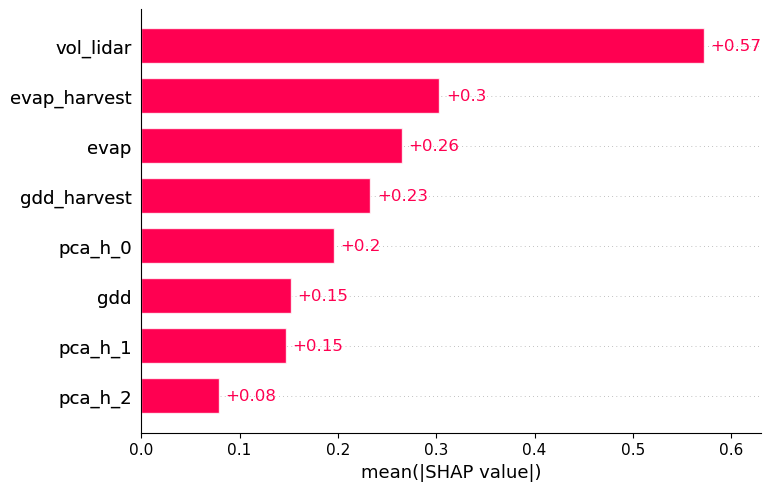

In [14]:
shap.plots.bar(shap_values_all_m)
shap.plots.bar(shap_values_all_h)

### Partial dependence plot

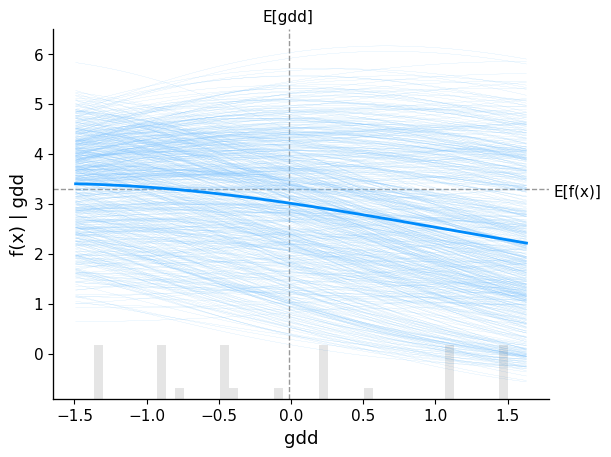

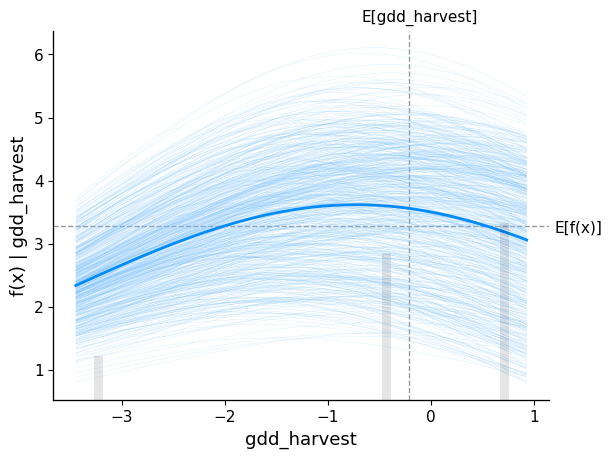

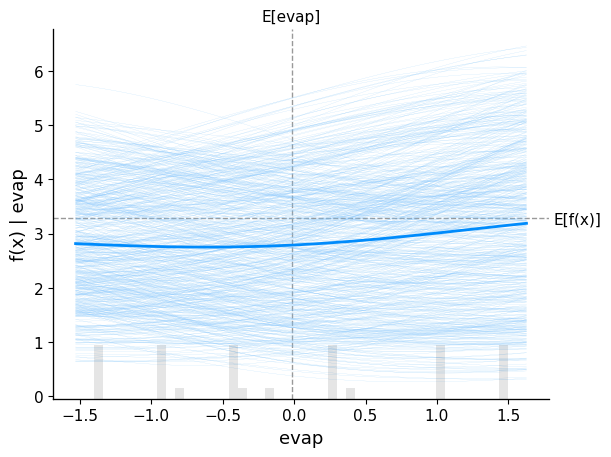

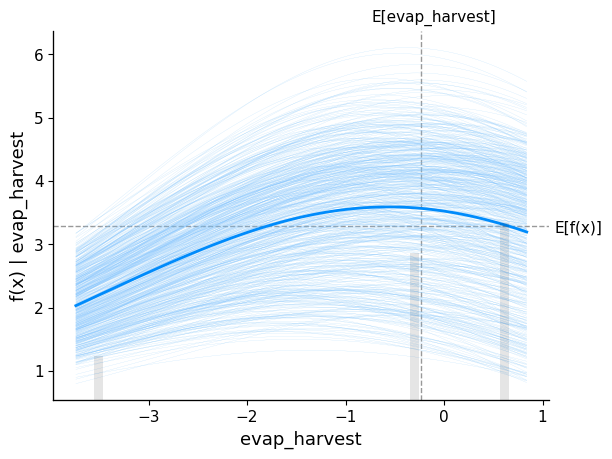

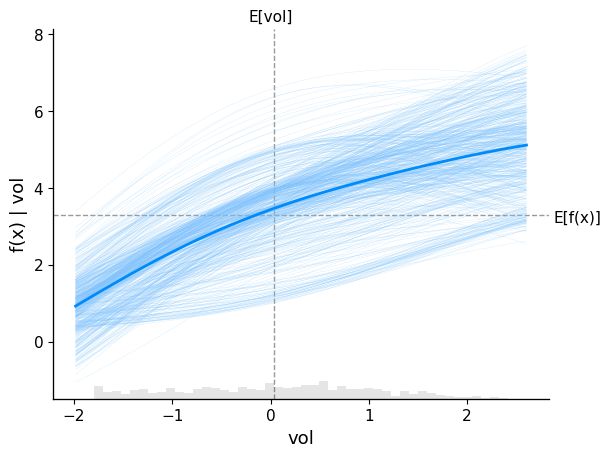

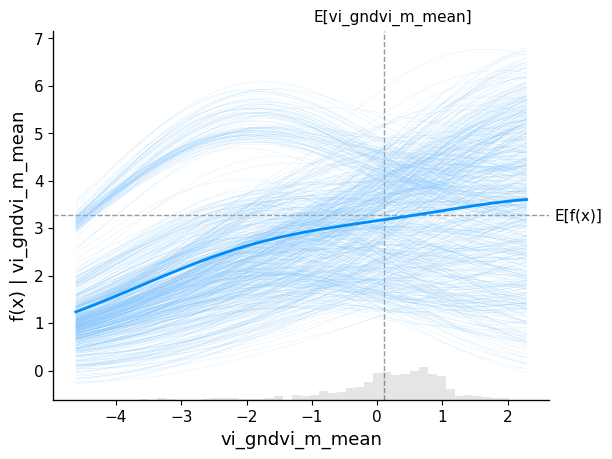

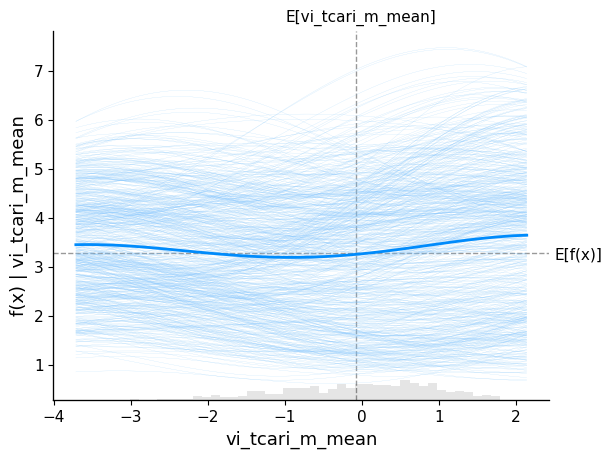

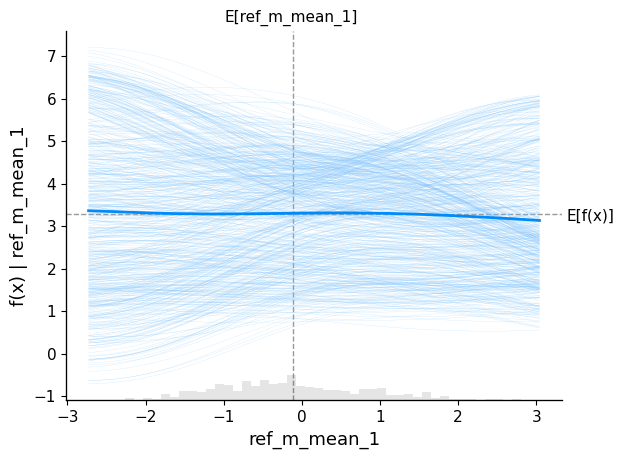

In [15]:
def plot_partial_dependence(model, feats, X_scaled):
    for feat in feats:
        shap.plots.partial_dependence(feat, model.predict, X_scaled[feats], model_expected_value=True, feature_expected_value=True, ice = True)

plot_partial_dependence(model_m, feat_m, scaler.transform(X))

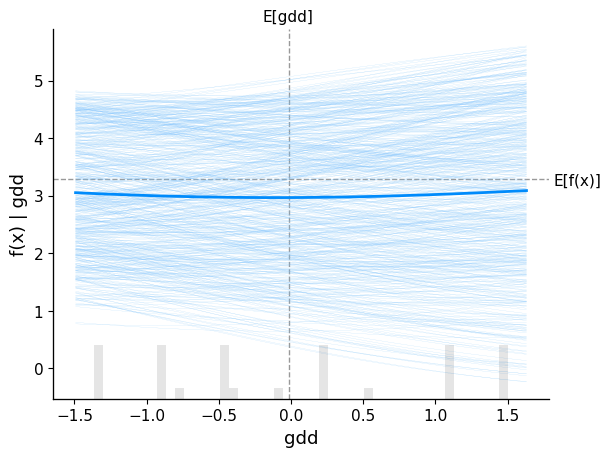

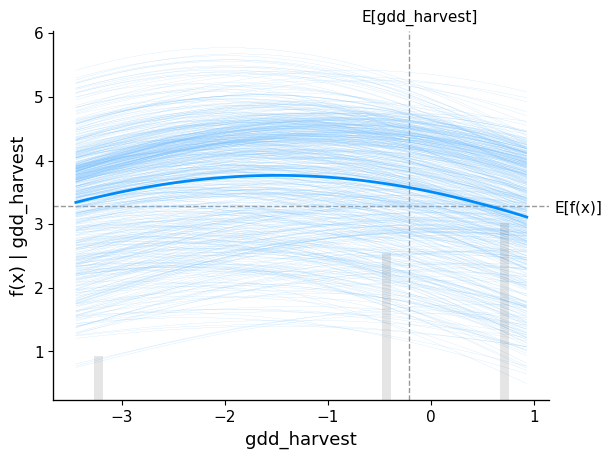

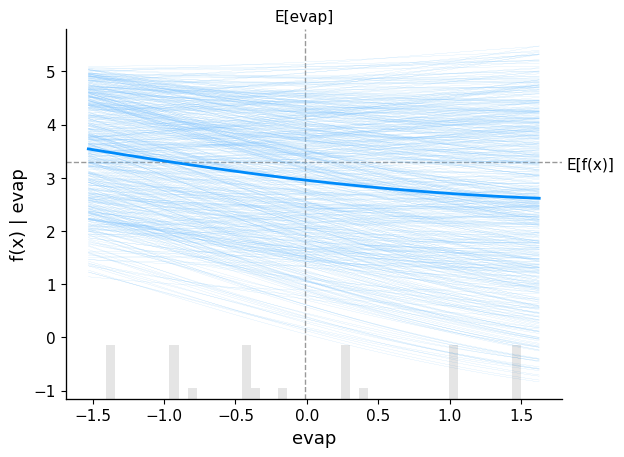

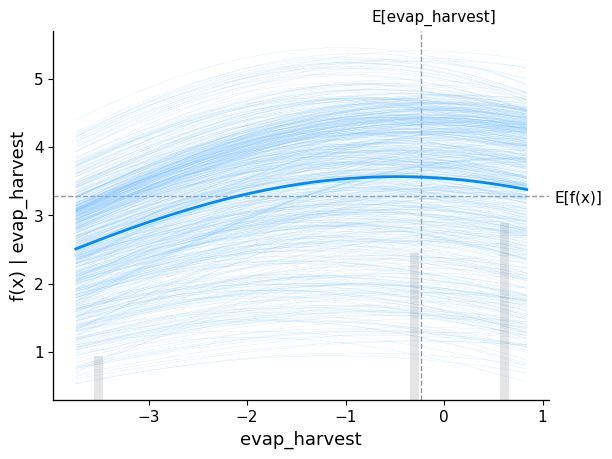

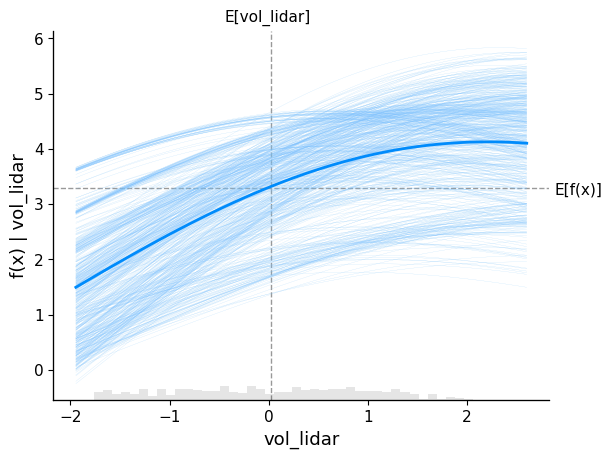

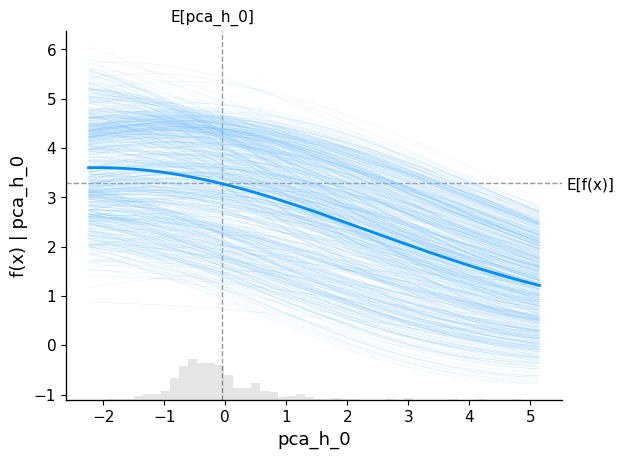

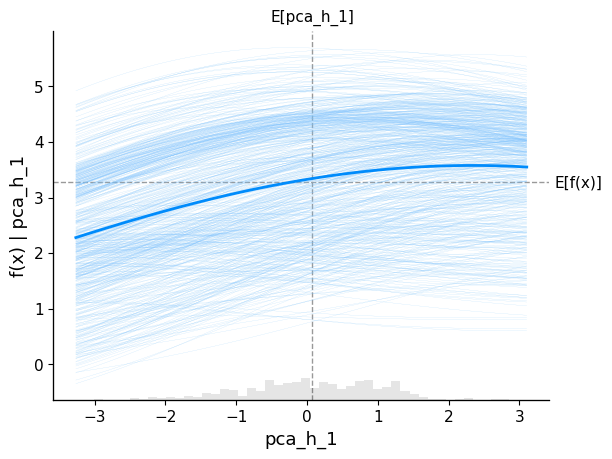

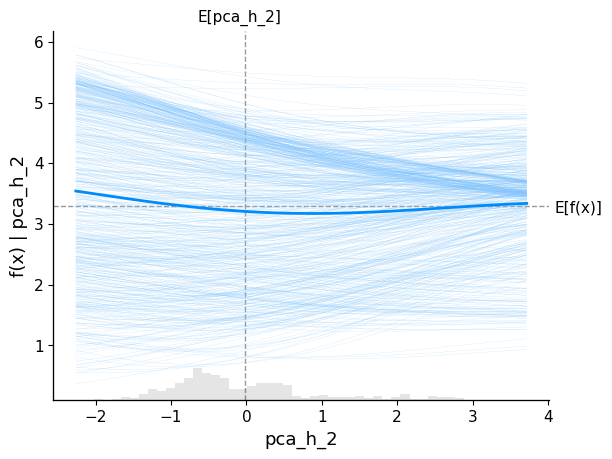

In [17]:
plot_partial_dependence(model_h, feat_h, scaler.transform(X))